<a href="https://colab.research.google.com/github/primacovolga-sys/analiza-energie/blob/main/Laboratorul_1_%E2%80%93_Analiza_Interactiv%C4%83_a_Energiei_04_11_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**0) Setup minimal în Colab (Drive + directoare)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
BASE = "/content/drive/MyDrive/Laborator1_Energie"
DATA_DIR = f"{BASE}/data"
OUT_DIR  = f"{BASE}/outputs"
os.makedirs(DATA_DIR, exist_ok=True); os.makedirs(OUT_DIR, exist_ok=True)
print("Pune fișierul CSV/XLSX aici:", DATA_DIR)


Mounted at /content/drive
Pune fișierul CSV/XLSX aici: /content/drive/MyDrive/Laborator1_Energie/data


**1) Setul de date + Preprocesare (Sarcinile 1.1–1.3)**

In [2]:
import glob, os, pandas as pd
files = sorted(glob.glob(os.path.join(DATA_DIR,"*.csv")) + glob.glob(os.path.join(DATA_DIR,"*.xlsx")))
assert files, f"Nu găsesc fișiere în {DATA_DIR}."
FILE = files[0]; print("Folosesc:", os.path.basename(FILE))
df_raw = pd.read_csv(FILE) if FILE.lower().endswith(".csv") else pd.read_excel(FILE)
df_raw.head(3)


Folosesc: data.csv


,date,carbune,consum,hidro,hidrocarburi,nuclear,eolian,productie,fotovolt,biomasa,stocare,sold
0,2025-08-31 21:08:21,587,6054,1746,1100,1348,808,5788,-4,48,152,266
1,2025-08-31 17:30:06,561,5111,877,600,1347,746,4541,320,47,42,570
2,2025-08-31 13:55:28,609,4971,564,440,1344,879,4344,461,46,0,626


**1C. Curățare + transformări (bifezi cerințele 1.1–1.2)**

In [3]:
import pandas as pd
from pandas.api.types import is_numeric_dtype

# 1) detectăm coloana de timp
tcands = [c for c in df_raw.columns if c.lower() in ["datetime","date","timestamp","time","ora","data"]]
if not tcands:
    tcands = [c for c in df_raw.columns if any(k in c.lower() for k in ["date","time","ora","data"])]
assert tcands, "Nu am găsit o coloană de timp."
time_col = tcands[0]

# 2) parse + sort
df = df_raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)

# 3) filtrează intervalul cerut în temă
START, END = "2024-01-01 00:00:00", "2025-08-31 23:59:59"
df = df[(df[time_col] >= START) & (df[time_col] <= END)].copy()

# 4) duplicate
before = len(df); df = df.drop_duplicates(); dups = before - len(df)

# 5) completări valori lipsă pe numeric (mediană)
num_cols = [c for c in df.columns if is_numeric_dtype(df[c])]
na_report = df[num_cols].isna().sum().sort_values(ascending=False)
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

# 6) categorice standardizate
cat_cols = [c for c in df.columns if not is_numeric_dtype(df[c]) and c != time_col]
for c in cat_cols:
    df[c] = df[c].astype(str).str.strip().str.lower()

# 7) descompuneri timp (an, lună, oră, minute, zi)
df["year"]   = df[time_col].dt.year
df["month"]  = df[time_col].dt.month
df["hour"]   = df[time_col].dt.hour
df["minute"] = df[time_col].dt.minute
df["weekday_name"] = df[time_col].dt.day_name()

print("Coloană timp:", time_col, "| duplicate eliminate:", dups)
print("Valori lipsă (numeric) înainte:", na_report.head(5))
df.head(3)


Coloană timp: date | duplicate eliminate: 0
Valori lipsă (numeric) înainte: carbune         0
consum          0
hidro           0
hidrocarburi    0
nuclear         0
dtype: int64


,date,carbune,consum,hidro,hidrocarburi,nuclear,eolian,productie,fotovolt,biomasa,stocare,sold,year,month,hour,minute,weekday_name
0,2025-01-01 04:00:25,704,5163,857,1614,1386,885,5506,-3,36,0,-342,2025,1,4,0,Wednesday
1,2025-01-01 07:38:25,711,5062,993,1481,1385,1017,5625,-2,38,0,-562,2025,1,7,38,Wednesday
2,2025-01-01 11:20:42,685,4365,809,1516,1386,888,5816,467,37,0,-1451,2025,1,11,20,Wednesday


**1D. (opțional) Variabilă „raport preț/calitate” – doar dacă ai asemenea coloane**

In [4]:
# Schimbă 'pret' și 'calitate' cu numele reale dacă există
if {"pret","calitate"}.issubset(set(map(str.lower, df.columns))):
    # găsește efectiv numele cu majuscule corecte
    cols_map = {c.lower(): c for c in df.columns}
    df["raport_pret_calitate"] = df[cols_map["pret"]] / df[cols_map["calitate"]].replace(0, pd.NA)


**1E. Explorare inițială – statistici descriptive (cerința 1.3)**

In [5]:
# Alegem toate coloanele de energie (tot ce pare sursă de producere)
energy_cols = [c for c in num_cols if any(k in c.lower() for k in
  ["solar","fotovolta","pv","eolian","wind","hidro","hydro","nuclear","coal","carbune","gas","gaz"])]

desc = df[energy_cols].describe().T.round(2) if energy_cols else pd.DataFrame()
print("Coloane energie găsite:", energy_cols[:10])
desc


Coloane energie găsite: ['carbune', 'hidro', 'hidrocarburi', 'nuclear', 'eolian']


,count,mean,std,min,25%,50%,75%,max
carbune,1393.0,809.24,197.67,226.0,700.0,802.0,904.0,1457.0
hidro,1393.0,1350.09,444.83,365.0,1031.0,1305.0,1618.0,2771.0
hidrocarburi,1393.0,1037.03,458.76,142.0,637.0,1112.0,1336.0,1891.0
nuclear,1393.0,1200.21,284.12,591.0,1276.0,1331.0,1373.0,1395.0
eolian,1393.0,638.31,545.65,-20.0,208.0,473.0,960.0,2725.0


2) Analiza corelațiilor

2A. Corelație „ora” vs „energie fotovoltaică”

In [6]:
import numpy as np

# detectăm o coloană fotovoltaică/fotovoltaic/pv
pv_cands = [c for c in df.columns if any(k in c.lower() for k in ["fotovolta","pv","solar"])]
pv_col = pv_cands[0] if pv_cands else None

if pv_col:
    corr = np.corrcoef(df["hour"], df[pv_col])[0,1]
    print(f"Corelația (Pearson) între oră și {pv_col}: {corr:.3f}")
else:
    print("Nu am găsit coloană fotovoltaică (pv/solar).")


Nu am găsit coloană fotovoltaică (pv/solar).


**2B. Heatmap „tipuri de energie × ore”**

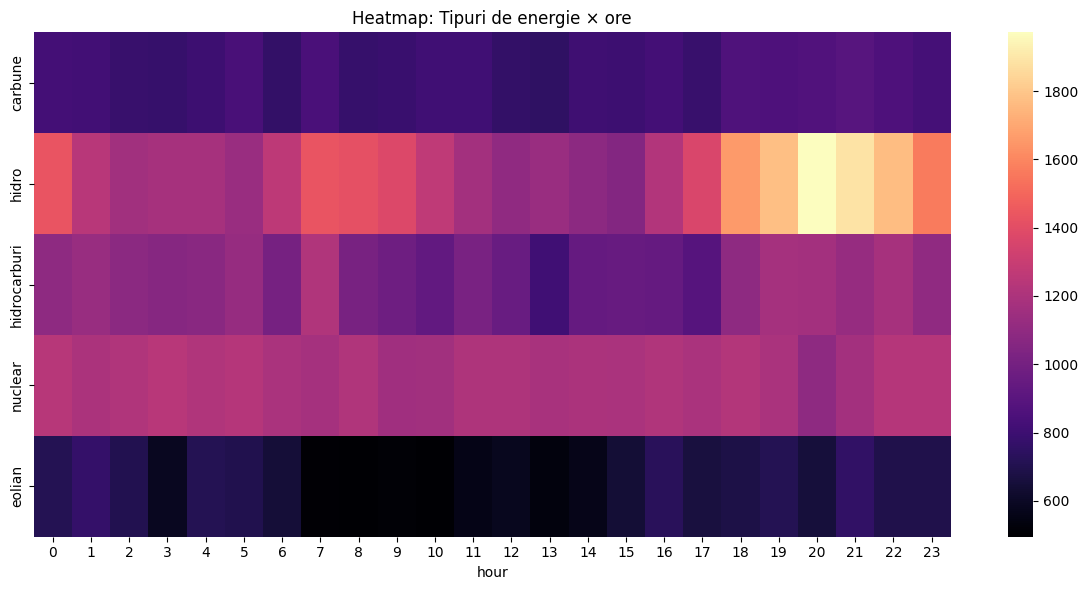

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np, os

assert energy_cols, "Setează manual energy_cols dacă nu s-au găsit automat."
pivot_hour = df.groupby("hour")[energy_cols].mean().T  # rânduri=tipuri, coloane=ore
plt.figure(figsize=(12,6))
sns.heatmap(pivot_hour, cmap="magma")
plt.title("Heatmap: Tipuri de energie × ore")
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,"heatmap_energy_by_hour.png"), dpi=150); plt.show()


**2C. Heatmap „tipuri de energie × luni”**

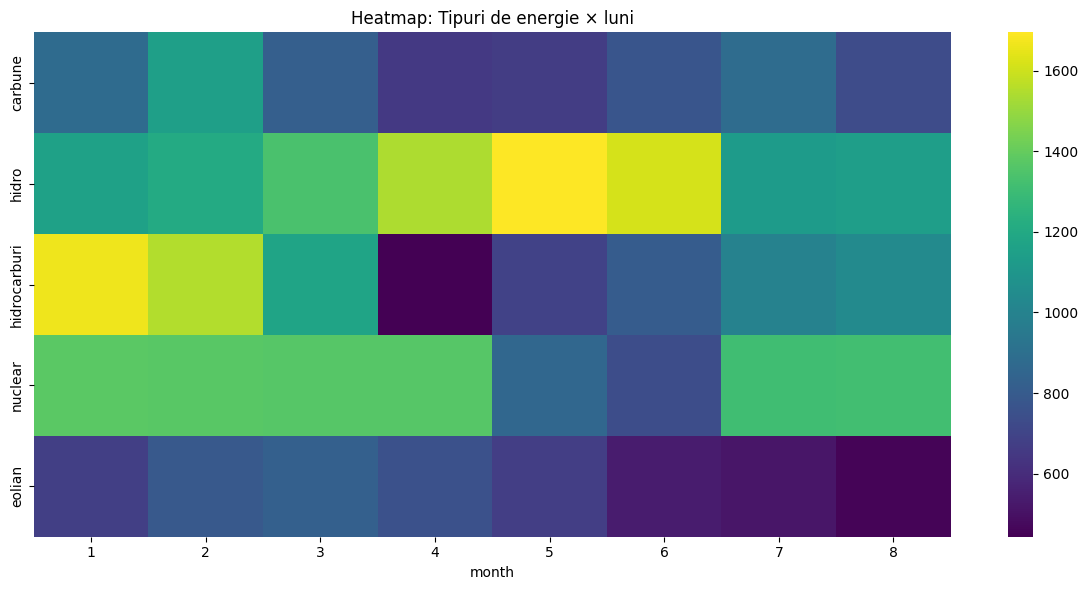

In [8]:
monthly = df.groupby("month")[energy_cols].mean().T
plt.figure(figsize=(12,6))
sns.heatmap(monthly, cmap="viridis")
plt.title("Heatmap: Tipuri de energie × luni")
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,"heatmap_energy_by_month.png"), dpi=150); plt.show()


3) Vizualizări avansate (toate cele 8 cerințe)

   definim totaluri + sold (producție – consum)

In [9]:
# încearcă să identifice total producție / consum
def pick_first(keys):
    for c in num_cols:
        if any(k in c.lower() for k in keys): return c

prod_total = pick_first(["prod_total","total_production","generation_total","generation","prod"])
cons_total = pick_first(["cons_total","consumption_total","demand","load","cons"])

if (not prod_total) and energy_cols:
    df["prod_total_auto"] = df[energy_cols].sum(axis=1, min_count=1)
    prod_total = "prod_total_auto"

if prod_total and cons_total:
    df["sold"] = df[prod_total] - df[cons_total]
else:
    df["sold"] = pd.NA

print("prod_total:", prod_total, "| cons_total:", cons_total)


prod_total: productie | cons_total: consum


**3.1 Producția lunară pe tipuri**

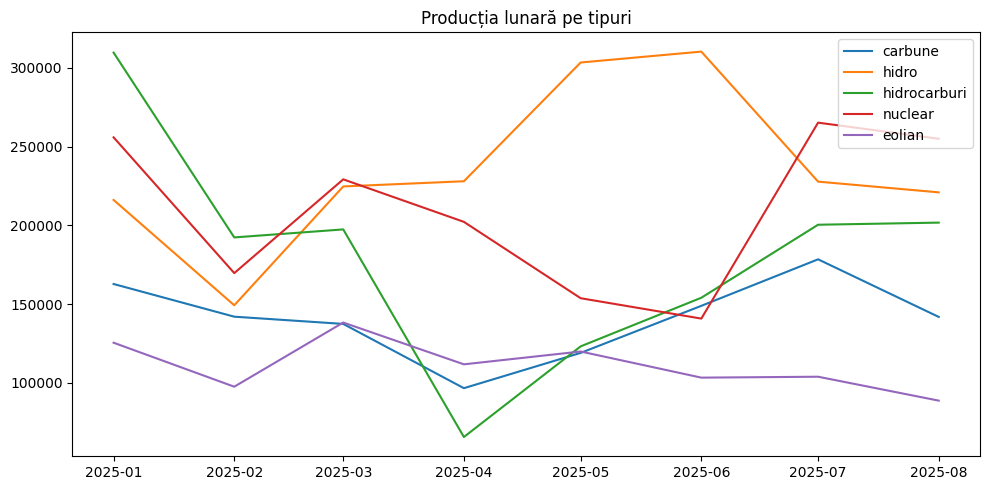

In [10]:
monthly_sum = df.groupby(["year","month"])[energy_cols].sum().reset_index()
monthly_sum["year_month"] = pd.to_datetime(monthly_sum["year"].astype(str)+"-"+monthly_sum["month"].astype(str)+"-01")
plt.figure(figsize=(10,5))
for c in energy_cols: plt.plot(monthly_sum["year_month"], monthly_sum[c], label=c)
plt.title("Producția lunară pe tipuri"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"viz1_monthly_types.png"), dpi=150); plt.show()


**3.2 Soldul zilnic (2024–2025)**

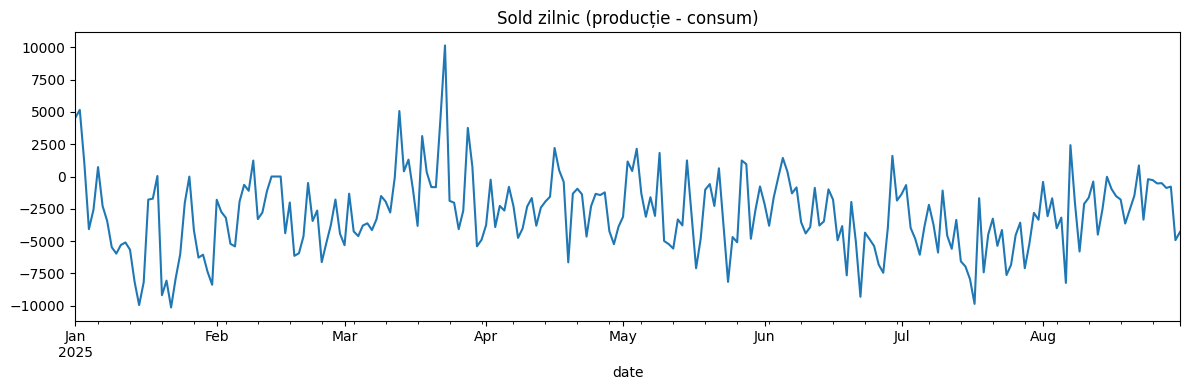

In [11]:
if "sold" in df and df["sold"].notna().any():
    daily_sold = df.set_index(time_col).groupby(pd.Grouper(freq="D"))["sold"].sum()
    daily_sold.plot(figsize=(12,4), title="Sold zilnic (producție - consum)"); plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR,"viz2_daily_sold.png"), dpi=150); plt.show()


**3.3 Seria temporală pe sold**

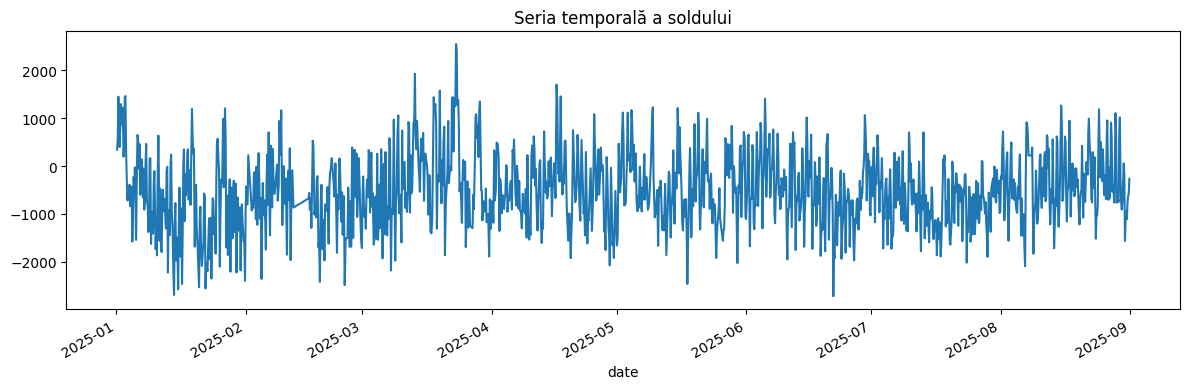

In [12]:
if "sold" in df and df["sold"].notna().any():
    df.set_index(time_col)["sold"].plot(figsize=(12,4), title="Seria temporală a soldului"); plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR,"viz3_ts_sold.png"), dpi=150); plt.show()


**3.4 Peak producție pe ore (max)**

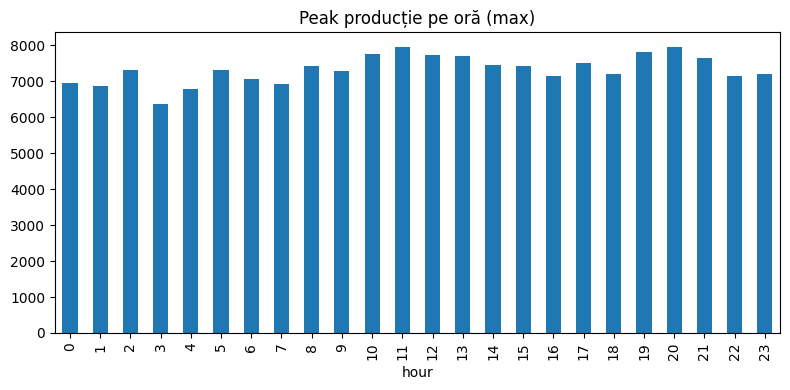

In [13]:
if prod_total:
    peak = df.groupby("hour")[prod_total].max()
    peak.plot(kind="bar", figsize=(8,4), title="Peak producție pe oră (max)")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,"viz4_peak_by_hour.png"), dpi=150); plt.show()


**3.5 Consumul mediu pe zilele săptămânii**

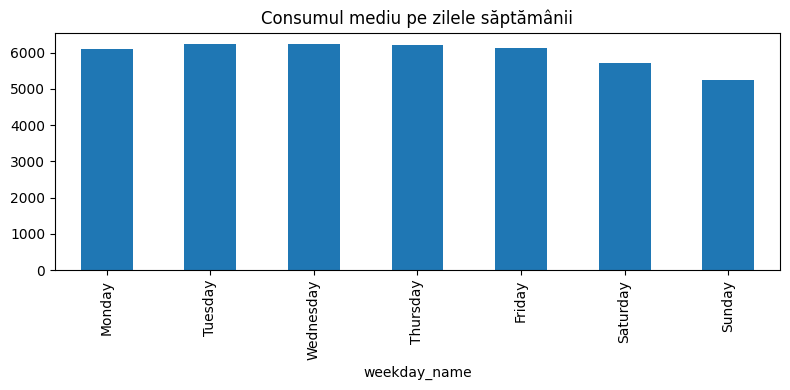

In [14]:
if cons_total:
    order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    wd = df.groupby("weekday_name")[cons_total].mean().reindex(order)
    wd.plot(kind="bar", figsize=(8,4), title="Consumul mediu pe zilele săptămânii")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,"viz5_avg_cons_by_weekday.png"), dpi=150); plt.show()


**3.6 Producția medie lunară 2024 vs 2025**

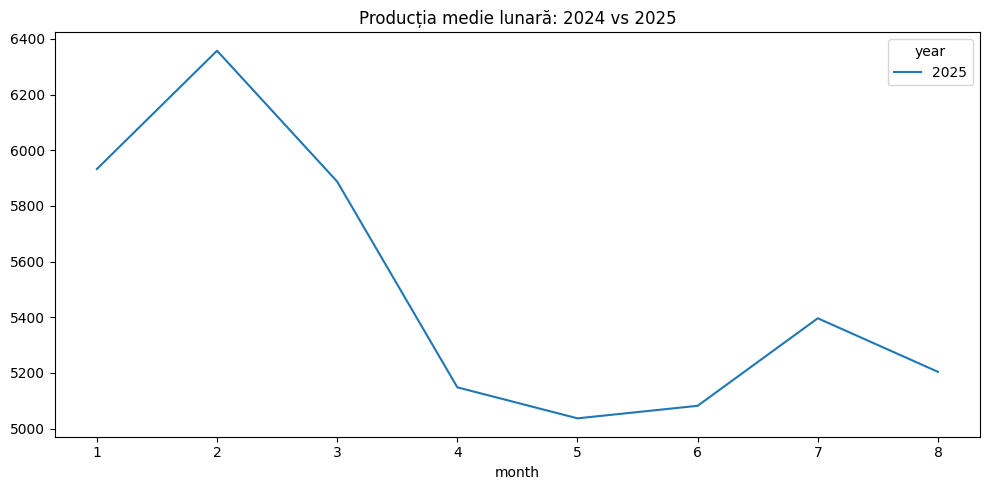

In [15]:
if prod_total:
    m = df.groupby(["year","month"])[prod_total].mean().unstack(0)  # coloane = anii
    m.plot(figsize=(10,5), title="Producția medie lunară: 2024 vs 2025")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,"viz6_mean_monthly_24_25.png"), dpi=150); plt.show()


**3.7 Comparare grafică consum vs producție (zilnic)**

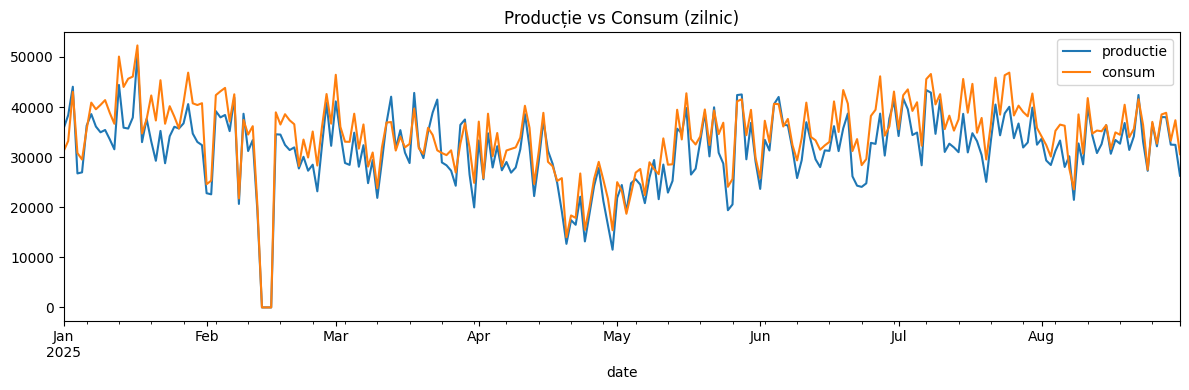

In [16]:
if prod_total and cons_total:
    dc = df.set_index(time_col).groupby(pd.Grouper(freq="D"))[[prod_total,cons_total]].sum()
    dc.plot(figsize=(12,4), title="Producție vs Consum (zilnic)")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,"viz7_prod_vs_cons_daily.png"), dpi=150); plt.show()


**3.8 Comparare 2024 vs 2025 (totaluri)**

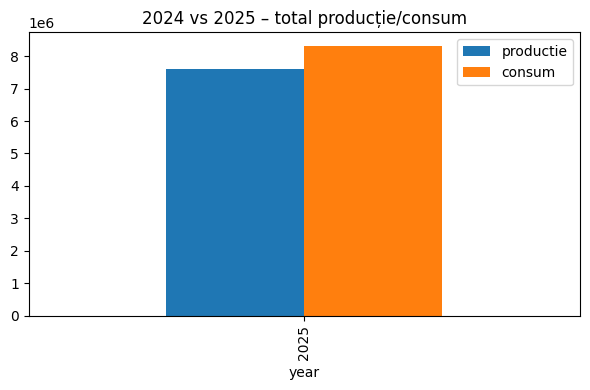

In [17]:
if prod_total and cons_total:
    by_year = df.groupby("year")[[prod_total,cons_total]].sum()
    by_year.plot(kind="bar", figsize=(6,4), title="2024 vs 2025 – total producție/consum")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,"viz8_2024_vs_2025_totals.png"), dpi=150); plt.show()


4) Aplicație Streamlit (filtre + grafice + PDF)

**4A. Scriem fișierul aplicației**

In [18]:
%%writefile streamlit_app.py
import streamlit as st
import pandas as pd
import io
from datetime import datetime
import plotly.express as px

st.set_page_config(page_title="Analiza Energiei", layout="wide")
st.title("Analiza Interactivă a Energiei – Streamlit")

uploaded = st.file_uploader("Încarcă CSV/XLSX", type=["csv","xlsx"])
if uploaded:
    df = pd.read_csv(uploaded) if uploaded.name.endswith(".csv") else pd.read_excel(uploaded)

    # detect timp
    tc = [c for c in df.columns if c.lower() in ["datetime","date","timestamp","time","ora","data"]]
    if not tc:
        tc = [c for c in df.columns if any(k in c.lower() for k in ["date","time","ora","data"])]
    if not tc:
        st.error("Nu am găsit o coloană de timp."); st.stop()
    t = tc[0]
    df[t] = pd.to_datetime(df[t], errors="coerce")
    df = df.dropna(subset=[t]).sort_values(t)

    # derivate
    df["year"]=df[t].dt.year; df["month"]=df[t].dt.month

    # coloane energie
    num_cols = df.select_dtypes("number").columns.tolist()
    energy_cols = [c for c in num_cols if any(k in c.lower() for k in
      ["solar","fotovolta","pv","eolian","wind","hidro","hydro","nuclear","coal","carbune","gas","gaz"])]

    # filtre
    st.sidebar.header("Filtre")
    dmin, dmax = df[t].min(), df[t].max()
    r = st.sidebar.date_input("Interval de date", (dmin.date(), dmax.date()))
    if isinstance(r, tuple): (start, end) = r
    else: start, end = dmin.date(), dmax.date()
    df = df[(df[t] >= pd.Timestamp(start)) & (df[t] <= pd.Timestamp(end))]

    chosen = st.sidebar.multiselect("Tipuri de energie", options=energy_cols, default=energy_cols[:5])

    # grafice
    if chosen:
        st.subheader("Serii temporale (selectate)")
        st.plotly_chart(px.line(df, x=t, y=chosen), use_container_width=True)

        fm = df.set_index(t).groupby(pd.Grouper(freq="M"))[chosen].sum().reset_index()
        st.subheader("Agregare lunară (sumă)")
        st.plotly_chart(px.bar(fm, x=t, y=chosen, barmode="group"), use_container_width=True)

    # PDF simplu (HTML → bytes)
    if st.button("Generează raport PDF (simplu)"):
        import pdfkit, tempfile, os
        html = "<h1>Raport Energie</h1>"
        html += f"<p>Perioadă: {start} – {end}</p>"
        if chosen:
            html += "<p>Tipuri: " + ", ".join(chosen) + "</p>"
        with tempfile.NamedTemporaryFile(delete=False, suffix=".html") as tmp:
            tmp.write(html.encode("utf-8")); tmp.flush()
            pdf_bytes = None
            try:
                # necesită wkhtmltopdf pe unele platforme; pe Streamlit Cloud există container – alternativ poți afișa HTML simplu
                pdf_bytes = pdfkit.from_file(tmp.name, False)
            except Exception:
                pdf_bytes = html.encode("utf-8")  # fallback: oferim HTML dacă nu e pdfkit
        st.download_button("Descarcă raport", data=pdf_bytes, file_name="raport.pdf" if pdf_bytes else "raport.html")


Writing streamlit_app.py


In [19]:
%%writefile requirements.txt
streamlit==1.39.0
pandas
plotly
reportlab


Writing requirements.txt


In [20]:
import shutil, os
BASE = "/content/drive/MyDrive/Laborator1_Energie/app_streamlit"
os.makedirs(BASE, exist_ok=True)
shutil.copy("/content/streamlit_app.py", BASE)
shutil.copy("/content/requirements.txt", BASE)
print("Am salvat în:", BASE)


Am salvat în: /content/drive/MyDrive/Laborator1_Energie/app_streamlit
